Se carga y selecciona datos de dos fuentes diferentes (una con los datos de las IMUs y otra con datos de la evaluación de los pacientes MDS UPDRS), se selecciona columnas específicas de los datos y se asigna los subconjuntos de datos resultantes a las variables data y patientsMds, respectivamente.

In [22]:
import numpy as np
import pandas as pd
from src.settings  import ROOT_DIR

data: pd.DataFrame = pd.read_pickle(ROOT_DIR / 'data' / 'processed' / 'anon_imu_data_time_series_cleaned.pkl')
used_columns = ['anon_id', 'date_measure', 'time_stamp', 'imu_accX_right', 'imu_accX_left','PD']
data = data[used_columns]
print(data.columns)
patientsMds:pd.DataFrame = pd.read_excel(ROOT_DIR / 'data' / 'raw' / 'patients_mdsupdrs_results.xlsx')
patientsMds_used_columns = ['Cédula','Temblor postural – Mano derecha','Temblor postural – Mano izquierda','Temblor de acción – Mano derecha','Temblor de acción – Mano izquierda']

Index(['anon_id', 'date_measure', 'time_stamp', 'imu_accX_right',
       'imu_accX_left', 'PD'],
      dtype='object')


Se crea un nuevo campo para no depender de la fecha para diferenciar cada muestra.

In [23]:
data['combined_id_date'] = data['anon_id'].astype(str) + '_' + data['date_measure'].astype(str)
print(data.tail())

       anon_id        date_measure  time_stamp  imu_accX_right  imu_accX_left  \
494723     179  2023-6-17-10-39-17     44757.0        8.601266       8.963518   
494724     179  2023-6-17-10-39-17     44798.0        7.113219       9.182925   
494725     179  2023-6-17-10-39-17     44839.0        5.800859       9.556166   
494726     179  2023-6-17-10-39-17     44880.0        5.117749       9.967539   
494727     179  2023-6-17-10-39-17     44900.0        5.303877      10.260220   

        PD        combined_id_date  
494723   0  179_2023-6-17-10-39-17  
494724   0  179_2023-6-17-10-39-17  
494725   0  179_2023-6-17-10-39-17  
494726   0  179_2023-6-17-10-39-17  
494727   0  179_2023-6-17-10-39-17  


Se realiza el cálculo de energía total por brazo.

In [24]:
df=data.copy()
# Agrupa los datos por 'date_measure'
grouped_data = df.groupby('combined_id_date')

# Inicializa listas para almacenar los resultados
energy_data = []

# Itera sobre cada grupo
for combined_id_date, group in grouped_data:
    # Obtén las señales de aceleración de ambos lados
    accX_right = group['imu_accX_right'].values
    accX_left = group['imu_accX_left'].values

    # Calcula la FFT de cada señal de aceleración
    fft_result_right = np.fft.fft(accX_right)
    fft_result_left = np.fft.fft(accX_left)

    # Calcula la magnitud de la FFT (utiliza np.abs para obtener el valor absoluto)
    fft_magnitude_right = np.abs(fft_result_right)
    fft_magnitude_left = np.abs(fft_result_left)

    # Calcula la energía total para cada acelerómetro
    total_energy_right = np.sum(fft_magnitude_right)
    total_energy_left = np.sum(fft_magnitude_left)

    # Almacena la energía total en la lista
    energy_data.append({'combined_id_date': combined_id_date, 'total_energy_right': total_energy_right, 'total_energy_left': total_energy_left,'PD': group['PD'].iloc[0]})

# Convierte la lista de resultados en un DataFrame
energy_df = pd.DataFrame(energy_data)

# Imprime el DataFrame con la energía total por medida
print(energy_df.columns)



Index(['combined_id_date', 'total_energy_right', 'total_energy_left', 'PD'], dtype='object')


In [25]:
print(energy_df['PD'].value_counts())

PD
1    85
0    81
Name: count, dtype: int64


In [26]:
# Filtrar las filas con valor 0 en la columna 'PD'
controls_energy_df = energy_df[energy_df['PD'] == 0].copy()

# Imprimir las primeras filas del DataFrame filtrado
print(controls_energy_df.head())

          combined_id_date  total_energy_right  total_energy_left  PD
1   101_2023-4-11-11-53-36       129787.679932      125539.803118   0
6   105_2023-9-30-14-39-22        60653.431170       65651.110298   0
10  108_2023-2-23-14-47-39        91121.859791      146683.804413   0
11    109_2023-9-30-8-50-2       250322.215762      240695.575659   0
12    10_2023-6-22-10-28-8        85653.639433      115495.635742   0


Se imprime una muestra específica para observar los resultados

In [27]:
# Suponiendo que 'energy_df' es tu DataFrame con los resultados de energía
specific_combined_id_date = '10_2023-6-22-10-28-8'

# Filtra el DataFrame para obtener solo las filas correspondientes a la fecha específica
specific_specific_combined_id_date_data = energy_df.loc[energy_df['combined_id_date'] == specific_combined_id_date]

# Muestra los resultados
print(specific_specific_combined_id_date_data)


        combined_id_date  total_energy_right  total_energy_left  PD
12  10_2023-6-22-10-28-8        85653.639433      115495.635742   0


Se cruzan las cédulas con las que ya se habían obtenido de anonimización para unir los dataframes.

In [28]:
from src.preprocessing.get_anon_id import get_anon_id

patientsMds = patientsMds[patientsMds_used_columns]
patientsMds['anon_id'] = patientsMds['Cédula'].astype(str).apply(get_anon_id)

patientsMds.head()



,Cédula,Temblor postural – Mano derecha,Temblor postural – Mano izquierda,Temblor de acción – Mano derecha,Temblor de acción – Mano izquierda,anon_id
0,4663131,0,1,0,0,11
1,25714829,1,1,0,0,87
2,10542415,1,0,0,0,32
3,10526776,0,0,0,0,27
4,25268997,1,1,0,0,78


In [29]:
patientsMds.count()

Cédula                                90
Temblor postural – Mano derecha       90
Temblor postural – Mano izquierda     90
Temblor de acción – Mano derecha      90
Temblor de acción – Mano izquierda    90
anon_id                               90
dtype: int64

Se borra la cédula para respetar privacidad de pacientes y re realiza un split para obtener las cédulas de los pacientes.

In [30]:
patientsMds.drop('Cédula', axis=1, inplace=True)

#Re-split para realizar el cruce por id
energy_df['id']=energy_df['combined_id_date'].str.split('_').str[0]


Unimos los dataframes por coincidencia en cédulas.

In [31]:
# Realizar la unión por las columnas 'id' y 'anon_id'
merged_df = pd.merge(energy_df, patientsMds, left_on='id', right_on='anon_id', how='inner')

# Eliminar la columna 'anon_id' si no es necesaria en el DataFrame final
merged_df.drop('anon_id', axis=1, inplace=True)
id_column = merged_df.pop('id')
merged_df.insert(1, 'id', id_column)

# Imprimir el DataFrame resultante para verificar
merged_df.head()
print(merged_df.columns)

Index(['combined_id_date', 'id', 'total_energy_right', 'total_energy_left',
       'PD', 'Temblor postural – Mano derecha',
       'Temblor postural – Mano izquierda', 'Temblor de acción – Mano derecha',
       'Temblor de acción – Mano izquierda'],
      dtype='object')


In [32]:
merged_df.count()

combined_id_date                      64
id                                    64
total_energy_right                    64
total_energy_left                     64
PD                                    64
Temblor postural – Mano derecha       64
Temblor postural – Mano izquierda     64
Temblor de acción – Mano derecha      64
Temblor de acción – Mano izquierda    64
dtype: int64

Creamos diferentes clases para dividir las medidas en tres grupos:
1: PD con temblor
0: Sin PD
-1: PD-rigidez



In [33]:
def classify_row(row):
    if row['PD'] == 1:
        if (row['Temblor postural – Mano derecha'] != 0 or
                row['Temblor postural – Mano izquierda'] != 0 or
                row['Temblor de acción – Mano derecha'] != 0 or
                row['Temblor de acción – Mano izquierda'] != 0):
            return 1
        else:
            return -1
    elif row['PD'] == 0:
        return 0
    else:
        return np.nan  # Otra clasificación

# Crear una nueva columna 'classification' aplicando la función a cada fila
merged_df['classification'] = merged_df.apply(classify_row, axis=1)

# Imprimir el DataFrame resultante
print(merged_df.head())

         combined_id_date   id  total_energy_right  total_energy_left  PD  \
0   102_2023-8-31-15-3-10  102        75142.285996       81240.302861   1   
1    102_2023-8-31-15-5-5  102        65801.483835      103992.161572   1   
2  103_2023-7-11-10-15-46  103           13.412852          24.038894   1   
3    104_2023-9-12-11-8-0  104       240563.682982      222068.000913   1   
4  106_2023-2-23-15-52-11  106       103817.726651      101727.156213   1   

   Temblor postural – Mano derecha  Temblor postural – Mano izquierda  \
0                                3                                  1   
1                                3                                  1   
2                                0                                  0   
3                                0                                  0   
4                                0                                  0   

   Temblor de acción – Mano derecha  Temblor de acción – Mano izquierda  \
0                      

Eliminamos las columnas de temblor y PD y nos quedamos con la clasificación. Quitamos tambien combined_id_date y id identificar pacientes no nos interesa en esta etapa

In [34]:
# Lista de columnas relacionadas con el temblor
columns_to_drop = ['Temblor postural – Mano derecha',
                   'Temblor postural – Mano izquierda',
                   'Temblor de acción – Mano derecha',
                   'Temblor de acción – Mano izquierda',
                   'PD','combined_id_date','id']

# Eliminar las columnas relacionadas con el temblor del DataFrame
merged_df.drop(columns=columns_to_drop, inplace=True)

# Imprimir el DataFrame resultante
merged_df.head()

,total_energy_right,total_energy_left,classification
0,75142.285996,81240.302861,1
1,65801.483835,103992.161572,1
2,13.412852,24.038894,-1
3,240563.682982,222068.000913,-1
4,103817.726651,101727.156213,-1


In [35]:
#revisión controles
controls_energy_df_sorted = controls_energy_df.sort_values(by='total_energy_right', ascending=False)
controls_energy_df_sorted.head()

,combined_id_date,total_energy_right,total_energy_left,PD
97,190_2023-10-5-16-23-50,2.287920e+06,2.202838e+06,0
94,188_2023-10-5-16-34-4,2.037657e+06,1.878446e+06,0
99,191_2023-10-5-16-14-35,1.932419e+06,2.212230e+06,0
132,59_2023-9-30-12-28-15,2.962891e+05,2.978095e+05,0
11,109_2023-9-30-8-50-2,2.503222e+05,2.406956e+05,0


Añadimos a los controles que fueron filtrados en el merge

In [36]:
columns_to_drop = ['combined_id_date']
controls_energy_df.drop(columns=columns_to_drop, inplace=True)
controls_energy_df.rename(columns={'PD': 'classification'}, inplace=True)
controls_energy_df.head()

,total_energy_right,total_energy_left,classification
1,129787.679932,125539.803118,0
6,60653.431170,65651.110298,0
10,91121.859791,146683.804413,0
11,250322.215762,240695.575659,0
12,85653.639433,115495.635742,0


In [37]:
print(controls_energy_df.columns)
print(merged_df.columns)

Index(['total_energy_right', 'total_energy_left', 'classification'], dtype='object')
Index(['total_energy_right', 'total_energy_left', 'classification'], dtype='object')


Graficamos los controles para ver los datos de mayor magnitud

In [38]:
controls_energy_df_sorted = controls_energy_df.sort_values(by='total_energy_right', ascending=False)
print(controls_energy_df_sorted.head())

     total_energy_right  total_energy_left  classification
97         2.287920e+06       2.202838e+06               0
94         2.037657e+06       1.878446e+06               0
99         1.932419e+06       2.212230e+06               0
132        2.962891e+05       2.978095e+05               0
11         2.503222e+05       2.406956e+05               0


Quitamos los 3 primeros datos que después de verlos parecen ser outliers

In [39]:
# Ordenar el DataFrame según la energía en la mano derecha en orden descendente
controls_energy_df_sorted = controls_energy_df.sort_values(by='total_energy_right', ascending=False)

# Eliminar las tres primeras filas del DataFrame resultante
controls_energy_df = controls_energy_df_sorted.iloc[3:]

# Verificar el cambio
print(controls_energy_df.head())


     total_energy_right  total_energy_left  classification
132       296289.123093      297809.453779               0
11        250322.215762      240695.575659               0
64        241357.240362      172745.340008               0
31        232691.438243      237991.973635               0
87        221998.092524      228087.541388               0


In [40]:
print(controls_energy_df_sorted.head())
print(controls_energy_df_sorted.tail())

     total_energy_right  total_energy_left  classification
97         2.287920e+06       2.202838e+06               0
94         2.037657e+06       1.878446e+06               0
99         1.932419e+06       2.212230e+06               0
132        2.962891e+05       2.978095e+05               0
11         2.503222e+05       2.406956e+05               0
     total_energy_right  total_energy_left  classification
39         28303.920486       31901.302183               0
56         19478.411460       13625.895951               0
104        14724.694769       28704.211307               0
148        12761.115720       13771.650789               0
86          5086.819156        4245.980096               0


In [41]:
# Agregar las filas de energy_df a merged_df
merged_df = pd.concat([merged_df, controls_energy_df], ignore_index=True)

# Verificar el cambio
print(merged_df.tail())


     total_energy_right  total_energy_left  classification
137        28303.920486       31901.302183               0
138        19478.411460       13625.895951               0
139        14724.694769       28704.211307               0
140        12761.115720       13771.650789               0
141         5086.819156        4245.980096               0


Se realiza el split de los datos en sus respectivos sets.

In [42]:
from src.utils.data_split import save_and_split

save_and_split(merged_df, 'tremor')

FileExistsError: [Errno 17] File exists: 'C:\\Users\\Usuario\\Documents\\PDG 2\\AIForIMUParkinsonData\\data\\processed\\tremor\\train.pkl'

In [ ]:
train_data=pd.read_pickle(ROOT_DIR / 'data' / 'processed' / 'tremor' / 'train.pkl')
train_data.columns

In [43]:
print(merged_df['classification'].value_counts())

classification
 0    78
-1    37
 1    27
Name: count, dtype: int64


Graficamos los datos para echar un vistazo a su distribución

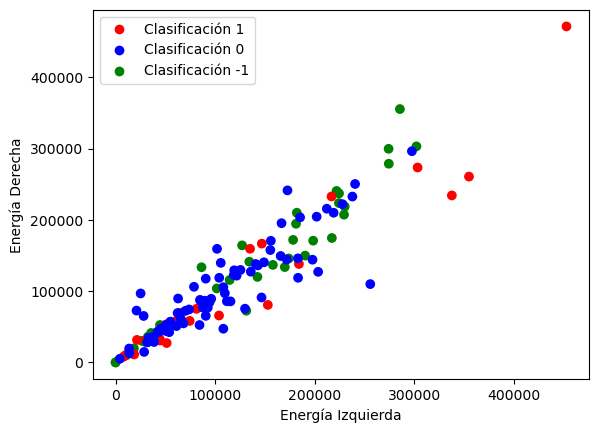

In [44]:
import matplotlib.pyplot as plt

# Colores para cada clasificación
colors = {1: 'red', 0: 'blue', -1: 'green'}

# Graficar los datos
plt.scatter(merged_df['total_energy_left'], merged_df['total_energy_right'], c=merged_df['classification'].map(colors))

# Establecer etiquetas de los ejes
plt.xlabel('Energía Izquierda')
plt.ylabel('Energía Derecha')

# Mostrar la leyenda con las clasificaciones
for classification, color in colors.items():
    plt.scatter([], [], color=color, label=f'Clasificación {classification}')
plt.legend()

# Mostrar el gráfico
plt.show()